## Martin Dionne

In [1]:
import tarfile
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split

#import tensorflow as tf
from tensorflow import keras

# FFNN
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

# RNN
from keras.preprocessing import sequence
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM

# 1. Sentiment analysis

Using the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), we want to do a regression model that predict the ratings are on a 1-10 scale. You have an example train and test set in the `dataset` folder.

### 1.1 Regression Model

Use a feedforward neural network and NLP techniques we've seen up to now to train the best model you can on this dataset

### 1.2 RNN model

Train a RNN to do the sentiment analysis regression. The RNN should consist simply of an embedding layer (to make word IDs into word vectors) a recurrent blocks (GRU or LSTM) feeding into an output layer.

In [2]:
def get_review(member):
    with tar.extractfile(member) as f:
        review = f.read().decode()
        return review

data = []
with tarfile.open("dataset/aclImdb_v1.tar.gz", "r:gz") as tar:
    for member in tar.getmembers():
        if member.isreg(): 
            if 'train' in member.name:
                if '/neg/' in member.name:
                    score_10 = member.name[-5:-4]
                    score = 0
                    data.append([get_review(member), score, score_10])
                elif '/pos/' in member.name:
                    score_10 = member.name[-6:-4].replace('_','')
                    score = 1
                    data.append([get_review(member), score, score_10])
                else:
                    pass

In [3]:
train = pd.DataFrame(data, columns = ['Review', 'Score', 'Score_10'])
#train.sample(5)

In [4]:
#test.to_csv('dataset/imdb_test.csv', index=False)
#train.to_csv('dataset/imdb_train.csv', index=False)

df = pd.read_csv('dataset/imdb_train.csv')
df = pd.concat([df, pd.read_csv('dataset/imdb_test.csv')])
df = df.sample(frac=.2).reset_index(drop=True)
df

,Review,Score,Score_10
0,"While the original 1932 version, with Preston ...",1,10
1,I found this movie to be a simple yet wonderfu...,1,10
2,A schizophrenic has escaped from a NYC mental ...,0,2
3,"I now that these days, some people wan't see a...",1,10
4,"No doubt about it, Rampling is gorgeous -- a c...",0,4
...,...,...,...
9995,THE GOOD: The acting were great especially Ter...,0,4
9996,"Ahh, Talespin! What can I say that hasn't alre...",1,10
9997,Not a box office success; no-one really knows ...,1,8
9998,The movie is about Anton Newcombe. The music a...,1,10


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub("\\s", " ", text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    #text = text.split(' ')
    return text

tfidf = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    max_features=3000
)

In [6]:
from keras.utils import to_categorical

X = tfidf.fit_transform(df["Review"]).toarray()
y = to_categorical(df["Score"])
#y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)

(8000, 3000)

In [7]:
# FFNN Model
num_classes = 2

model = keras.Sequential()
# Input layer
model.add(Dense(1600, input_dim=3000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(400))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1600)              4801600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6400      
_________________________________________________________________
activation (Activation)      (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               640400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0

In [8]:
# Fit and evaluate
batch_size = 128
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/10
54/54 [==============================] - 12s 178ms/step - loss: 0.6587 - accuracy: 0.6444 - val_loss: 0.6266 - val_accuracy: 0.5658
Epoch 2/10
54/54 [==============================] - 7s 139ms/step - loss: 0.3056 - accuracy: 0.9118 - val_loss: 0.6379 - val_accuracy: 0.5233
Epoch 3/10
54/54 [==============================] - 8s 141ms/step - loss: 0.2336 - accuracy: 0.9554 - val_loss: 0.6571 - val_accuracy: 0.5133
Epoch 4/10
54/54 [==============================] - 8s 139ms/step - loss: 0.1829 - accuracy: 0.9820 - val_loss: 0.6580 - val_accuracy: 0.5250
Epoch 5/10
54/54 [==============================] - 9s 159ms/step - loss: 0.1449 - accuracy: 0.9936 - val_loss: 0.6545 - val_accuracy: 0.5525
Epoch 6/10
54/54 [==============================] - 9s 163ms/step - loss: 0.1224 - accuracy: 0.9969 - val_loss: 0.6087 - val_accuracy: 0.6100
Epoch 7/10
54/54 [==============================] - 8s 156ms/step - loss: 0.1047 - accuracy: 0.9988 - val_loss: 0.5325 - val_accuracy: 0.7025
Epoch

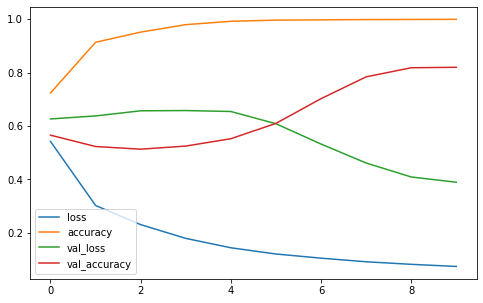

In [9]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab = 3000
max_len = 500

df['Review'] = df['Review'].apply(lambda x: clean_text(x))
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(df['Review'])
X = tokenizer.texts_to_sequences(df['Review'])
#y = to_categorical(df["Score"])
y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#np.shape(X_train)

In [11]:
# GRU Model
num_classes = 1

model = keras.Sequential()
# Input layer
model.add(Embedding(vocab, 128, input_length=max_len))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(num_classes, activation='sigmoid'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          384000    
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 491,393
Trainable params: 491,393
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Fit and evaluate

batch_size = 64
epochs = 5

X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/5
107/107 [==============================] - 567s 5s/step - loss: 0.6699 - accuracy: 0.5757 - val_loss: 0.4814 - val_accuracy: 0.7633
Epoch 2/5
107/107 [==============================] - 628s 6s/step - loss: 0.3686 - accuracy: 0.8429 - val_loss: 0.3883 - val_accuracy: 0.8425
Epoch 3/5
107/107 [==============================] - 634s 6s/step - loss: 0.2696 - accuracy: 0.8976 - val_loss: 0.3936 - val_accuracy: 0.8300
Epoch 4/5
107/107 [==============================] - 627s 6s/step - loss: 0.1844 - accuracy: 0.9288 - val_loss: 0.4117 - val_accuracy: 0.8300
Epoch 5/5
107/107 [==============================] - 661s 6s/step - loss: 0.1334 - accuracy: 0.9502 - val_loss: 0.4852 - val_accuracy: 0.8175
Loss: 53.91
Accuracy: 82.05


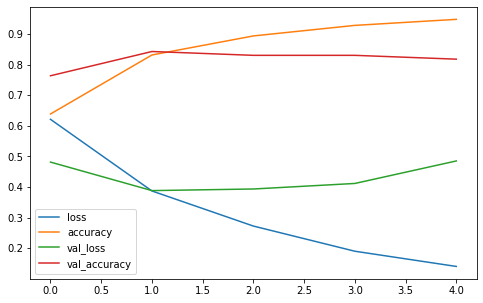

In [13]:
pd.DataFrame(history.history).plot(figsize=(8,5));

# 2. (evil) XOR Problem

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

### 2.1 

Generate a dataset of random <=100,000 binary strings of equal length <= 50. Train the LSTM; what is the maximum length you can train up to with precisison?
    

### 2.2

Generate a dataset of random <=200,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [14]:
def generate_bits(nval=100_000, length=50, random=False, pairs=True):
    if random:
        X = [ [np.random.randint(2) for l in range(np.random.randint(1,length))] for n in range(nval) ]
        X = np.array(sequence.pad_sequences(X, maxlen=length))
    else:
        X = np.random.randint(2, size=(nval, length))

    Y = [np.cumsum(x) % 2 for x in X]
    
    if pairs:
        make_pairs = lambda z: [z, int(not(z))]
        X = [ [make_pairs(j) for j in i] for i in X ]
        Y = [ [make_pairs(j) for j in i] for i in Y ]

    return  np.array(X), np.array(Y)

In [17]:
nval = 100_000
length = 50

X, Y = generate_bits(nval=100_000, length=50, random=False, pairs=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
np.shape(X_train)

(80000, 50, 2)

In [18]:
# LSTM model (fixed length)

model = keras.Sequential()

model.add(Input(shape=(length, 2), dtype='float32'))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 1)             16        
_________________________________________________________________
dense_6 (Dense)              (None, 50, 2)             4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit and evaluate

batch_size = 128
epochs = 10

history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, Y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/10
532/532 [==============================] - 22s 32ms/step - loss: 0.6931 - accuracy: 0.5091 - val_loss: 0.6929 - val_accuracy: 0.5073
Epoch 2/10
532/532 [==============================] - 15s 28ms/step - loss: 0.6928 - accuracy: 0.5093 - val_loss: 0.6925 - val_accuracy: 0.5151
Epoch 3/10
532/532 [==============================] - 14s 26ms/step - loss: 0.6921 - accuracy: 0.5150 - val_loss: 0.6897 - val_accuracy: 0.5198
Epoch 4/10
532/532 [==============================] - 14s 26ms/step - loss: 0.6868 - accuracy: 0.5342 - val_loss: 0.6623 - val_accuracy: 0.6223
Epoch 5/10
532/532 [==============================] - 14s 27ms/step - loss: 0.5427 - accuracy: 0.7867 - val_loss: 0.2522 - val_accuracy: 1.0000
Epoch 6/10
532/532 [==============================] - 14s 26ms/step - loss: 0.2292 - accuracy: 1.0000 - val_loss: 0.1780 - val_accuracy: 1.0000
Epoch 7/10
532/532 [==============================] - 14s 26ms/step - loss: 0.1662 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy:

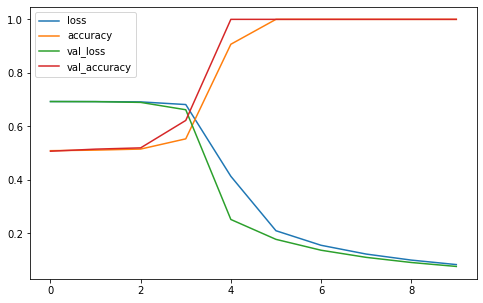

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [21]:
nval = 200_000
length = 50

X, Y = generate_bits(nval=200_000, length=50, random=True, pairs=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
np.shape(X_train)

(160000, 50, 2)

In [22]:
# LSTM model (random length)

model = keras.Sequential()

model.add(Input(shape=(length, 2), dtype='float32'))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 1)             16        
_________________________________________________________________
dense_7 (Dense)              (None, 50, 2)             4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Fit and evaluate
batch_size = 128
epochs = 5

history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, Y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/5
1063/1063 [==============================] - 35s 28ms/step - loss: 0.5583 - accuracy: 0.7506 - val_loss: 0.4329 - val_accuracy: 0.7523
Epoch 2/5
1063/1063 [==============================] - 29s 27ms/step - loss: 0.4124 - accuracy: 0.7513 - val_loss: 0.3558 - val_accuracy: 0.7734
Epoch 3/5
1063/1063 [==============================] - 32s 30ms/step - loss: 0.3469 - accuracy: 0.7828 - val_loss: 0.2477 - val_accuracy: 0.9280
Epoch 4/5
1063/1063 [==============================] - 32s 30ms/step - loss: 0.1689 - accuracy: 0.9828 - val_loss: 0.0876 - val_accuracy: 1.0000
Epoch 5/5
1063/1063 [==============================] - 31s 29ms/step - loss: 0.0783 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 1.0000
Loss: 5.65
Accuracy: 100.00


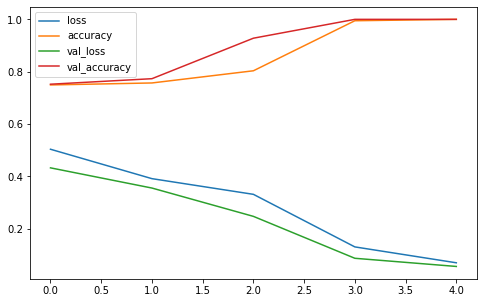

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [ ]:
# random (smaller) lengths of bits converge faster